In [17]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [18]:
import os
import numpy as np
from collections import OrderedDict as OD
import uproot3
import hist
import matplotlib.pyplot as plt
import mplhep as hep

#sIpFile = '/eos/cms/store/user/ssawant/htoaa/analysis/20230622_DataVsMC_GoldenJsonHEMIssue/2018/analyze_htoaa_stage1.root'
#sOpDir  = '/eos/cms/store/user/ssawant/htoaa/analysis/20230622_DataVsMC_GoldenJsonHEMIssue/2018/plots_2'
sIpFile = '/eos/cms/store/user/ssawant/htoaa/analysis/20230802_QCD_nbCats/2018/analyze_htoaa_stage1.root'
sOpDir  = '/eos/cms/store/user/ssawant/htoaa/analysis/20230802_QCD_nbCats/2018/plots'



if not os.path.exists(sOpDir):
    os.makedirs(sOpDir)
    
fIpFile = uproot3.open(sIpFile)

In [19]:
fIpFile['evt/SUSY_GluGluH_01J_HToAATo4B_M-20_HPtAbv150'].keys()

[b'hCutFlow_central;1',
 b'hCutFlowWeighted_central;1',
 b'hNEventsQCD_central;1',
 b'hNEventsQCDUnweighted_central;1',
 b'hGenLHE_HT_all_central;1',
 b'hGenLHE_HTIncoming_all_central;1',
 b'hGenLHE_Vpt_all_central;1',
 b'hGenLHE_AlphaS_all_central;1',
 b'hGenLHE_Njets_all_central;1',
 b'hGenLHE_Nb_all_central;1',
 b'hGenLHE_Nc_all_central;1',
 b'hGenLHE_Nuds_all_central;1',
 b'hGenLHE_Nglu_all_central;1',
 b'hGenLHE_NpNLO_all_central;1',
 b'hGenLHE_NpLO_all_central;1',
 b'hPileup_nTrueInt_central;1',
 b'hPileup_nPU_central;1',
 b'hPV_npvs_beforeSel_central;1',
 b'hPV_npvsGood_beforeSel_central;1',
 b'hGenHiggsPt_all_central;1',
 b'hGenHiggsPt_GenHToAATo4B_central;1',
 b'hGenHiggsPt_sel_central;1',
 b'hGenHiggsPt_sel_wGenCuts_central;1',
 b'hGenHiggsMass_all_0_central;1',
 b'hMass_GenA_all_0_central;1',
 b'hGenHiggsMass_all_central;1',
 b'hMass_GenA_all_central;1',
 b'hMass_GenAApair_all_central;1',
 b'hMass_GenAToBBbarpair_all_central;1',
 b'hMass_Gen4BFromHToAA_all_central;1',
 b'hMa

In [20]:
h = fIpFile['evt/SUSY_GluGluH_01J_HToAATo4B_M-20_HPtAbv150/hLeadingFatJetMass_central']

In [21]:
type(h)

uproot3.rootio.TH1D

In [22]:
h.values

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [23]:
h.edges

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [24]:
h.variances

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [25]:
np.sqrt(h.variances)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [26]:
np.sqrt(h.variances).shape

(300,)

In [27]:
h.values.shape

(300,)

In [28]:
h.edges.shape

(301,)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

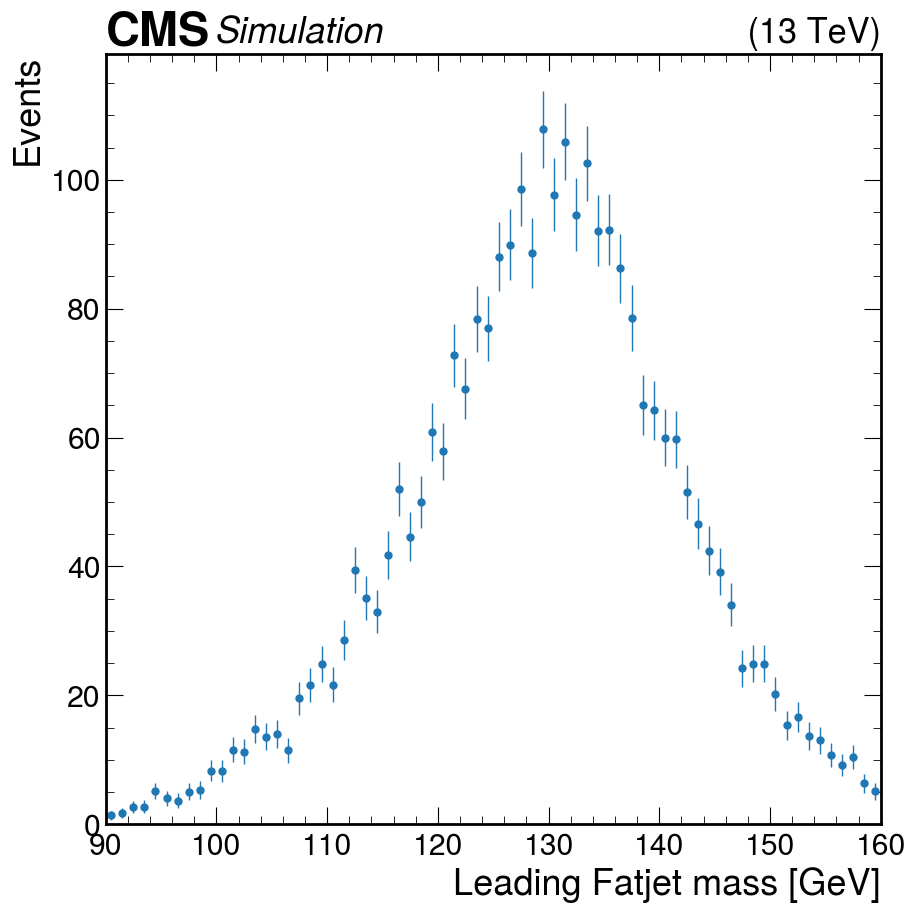

In [29]:
#plt.style.use([hep.style.ROOT])
plt.style.use([hep.style.CMS])

fig, axis = plt.subplots()
#hep.histplot(h, ax=axis, yerr=np.sqrt(h.variances))
hep.histplot(h.values, bins=h.edges, ax=axis, yerr=np.sqrt(h.variances), histtype='errorbar')
axis.set_xlim(90, 160)
axis.set_xlabel('Leading Fatjet mass [GeV]')
axis.set_ylabel('Events')

hep.cms.label(data=False)

In [30]:
fIpFile['evt'].keys()

[b'Data;1',
 b'QCD;1',
 b'QCD_0bCat;1',
 b'QCD_1bCat;1',
 b'QCD_2bCat;1',
 b'QCD_3bCat;1',
 b'QCD_4bCat;1',
 b'QCD_5bAndMoreCat;1',
 b'TTJets_NLO;1',
 b'TTJets_Incl;1',
 b'TTJets_HT;1',
 b'ZJetsToQQ_HT;1',
 b'WJetsToQQ_HT;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-12_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-12_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-15_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-15_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-20_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-20_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-25_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-25_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-30_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-30_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-35_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-35_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-40_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-40_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-45_Incl;1',
 b'SUSY_GluGluH_01J_HToAATo4B_M-45_HPtAbv150;1',
 b'SUSY_GluGluH_01J_HToAATo4B_

In [31]:
fIpFile['evt/Data'].keys()

[b'hCutFlow_noweight;1',
 b'hCutFlowWeighted_noweight;1',
 b'hNEventsQCD_noweight;1',
 b'hNEventsQCDUnweighted_noweight;1',
 b'hGenLHE_HT_all_noweight;1',
 b'hGenLHE_HTIncoming_all_noweight;1',
 b'hGenLHE_Vpt_all_noweight;1',
 b'hGenLHE_AlphaS_all_noweight;1',
 b'hGenLHE_Njets_all_noweight;1',
 b'hGenLHE_Nb_all_noweight;1',
 b'hGenLHE_Nc_all_noweight;1',
 b'hGenLHE_Nuds_all_noweight;1',
 b'hGenLHE_Nglu_all_noweight;1',
 b'hGenLHE_NpNLO_all_noweight;1',
 b'hGenLHE_NpLO_all_noweight;1',
 b'hPileup_nTrueInt_noweight;1',
 b'hPileup_nPU_noweight;1',
 b'hPV_npvs_beforeSel_noweight;1',
 b'hPV_npvsGood_beforeSel_noweight;1',
 b'hGenHiggsPt_all_noweight;1',
 b'hGenHiggsPt_GenHToAATo4B_noweight;1',
 b'hGenHiggsPt_sel_noweight;1',
 b'hGenHiggsPt_sel_wGenCuts_noweight;1',
 b'hGenHiggsMass_all_0_noweight;1',
 b'hMass_GenA_all_0_noweight;1',
 b'hGenHiggsMass_all_noweight;1',
 b'hMass_GenA_all_noweight;1',
 b'hMass_GenAApair_all_noweight;1',
 b'hMass_GenAToBBbarpair_all_noweight;1',
 b'hMass_Gen4BFro

In [32]:
sXRange = "xAxisRange"; sYRange = "yAxisRange";
sXLabel = 'xAxisLabel'; sYLabel = 'yAxisLabel';

era = 2018
luminosity = 54.54  #59.83
cmsWorkStatus='Work in Progress'

sData = "Data"
#MCBkg_list = ['QCD_bEnrich', 'QCD_bGen', 'QCD_Incl', 'TTJets_NLO', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
#MCBkg_list = ['QCD_bEnrich', 'QCD_bGen', 'QCD_Incl', 'TTJets_HT', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
#MCBkg_list = ['QCD_bEnrich', 'QCD_bGen', 'QCD_Incl', 'TTJets_Incl', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
MCBkg_list = ['QCD_0bCat', 'QCD_1bCat', 'QCD_2bCat', 'QCD_3bCat', 'QCD_4bCat', 'QCD_5bAndMoreCat',  'TTJets_NLO', 'WJetsToQQ_HT', 'ZJetsToQQ_HT']
MCSig_list = ['SUSY_GluGluH_01J_HToAATo4B_M-20_HPtAbv150']
sLableSig = 'HToAATo4B_M-20'
systematics_list = ['central']
systematics_forData = 'noweight'

scale_MCSig = 50 #1000


histograms_dict = OD([
    #("hLeadingFatJetMass", {sXLabel: 'Leading FatJet mass [GeV]', sYLabel: 'Events', sXRange: [50, 250], sYRange: [1e-2, 1e8]})
    #("hLeadingFatJetMass", {sXLabel: 'Leading FatJet mass [GeV]', sYLabel: 'Events', sXRange: [50, 250]}),
    
    #("", {sXLabel: '', sYLabel: 'Events', sXRange: []}),
    
    #("hCutFlow", {sXLabel: 'hCutFlow', sYLabel: 'Events'}),
    #("hCutFlowWeighted", {sXLabel: 'hCutFlowWeighted', sYLabel: 'Events'}),

    #("hPV_npvs_beforeSel", {sXLabel: 'No. of primary vertices before selection', sYLabel: 'Events', sXRange: [0, 100] }),
    #("hPV_npvsGood_beforeSel", {sXLabel: 'No. of good primary vertices before selection', sYLabel: 'Events', sXRange: [0, 100] }),
    ("hPV_npvs_SR", {sXLabel: 'No. of primary vertices in SR', sYLabel: 'Events', sXRange: [0, 100] }),
    ("hPV_npvsGood_SR", {sXLabel: 'No. of good primary vertices in SR', sYLabel: 'Events', sXRange: [0, 100] }),

    ("hLeadingFatJetPt", {sXLabel: 'hLeadingFatJetPt', sYLabel: 'Events', sXRange: [180, 1000] }),
    ("hLeadingFatJetEta", {sXLabel: 'hLeadingFatJetEta', sYLabel: 'Events', sXRange: [-3.5, 3.5] }),
    ("hLeadingFatJetPhi", {sXLabel: 'hLeadingFatJetPhi', sYLabel: 'Events', sXRange: [-3.14, 3.14] }),

    ("hLeadingFatJetPt_HEM1516IssueEtaPhiCut", {sXLabel: 'hLeadingFatJetPt_HEM1516IssueEtaPhiCut', sYLabel: 'Events', sXRange: [180, 1000] }),
    ("hLeadingFatJetEta_HEM1516IssuePhiCut", {sXLabel: 'hLeadingFatJetEta_HEM1516IssuePhiCut', sYLabel: 'Events', sXRange: [-3.5, 3.5] }),
    ("hLeadingFatJetPhi_HEM1516IssueEtaCut", {sXLabel: 'hLeadingFatJetPhi_HEM1516IssueEtaCut', sYLabel: 'Events', sXRange: [-3.14, 3.14] }),

    ("hLeadingFatJetMass", {sXLabel: 'hLeadingFatJetMass', sYLabel: 'Events', sXRange: [50, 300]}),
    ("hLeadingFatJetMSoftDrop", {sXLabel: 'hLeadingFatJetMSoftDrop', sYLabel: 'Events', sXRange: [50, 300] }),
    ("hLeadingFatJetBtagDeepB", {sXLabel: 'hLeadingFatJetBtagDeepB', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetBtagDDBvLV2", {sXLabel: 'hLeadingFatJetBtagDDBvLV2', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetBtagDDCvBV2", {sXLabel: 'hLeadingFatJetBtagDDCvBV2', sYLabel: 'Events', sXRange: [0, 1] }),
    
    ("hLeadingFatJetBtagHbb", {sXLabel: 'hLeadingFatJetBtagHbb', sYLabel: 'Events', sXRange: [-1, 1] }),
    ("hLeadingFatJetDeepTagMD_H4qvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_H4qvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTagMD_HbbvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_HbbvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTagMD_ZHbbvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_ZHbbvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTagMD_ZHccvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_ZHccvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    
    ("hLeadingFatJetDeepTagMD_ZbbvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_ZbbvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTagMD_ZvsQCD", {sXLabel: 'hLeadingFatJetDeepTagMD_ZvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTagMD_bbvsLight", {sXLabel: 'hLeadingFatJetDeepTagMD_bbvsLight', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTagMD_ccvsLight", {sXLabel: 'hLeadingFatJetDeepTagMD_ccvsLight', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTag_H", {sXLabel: 'hLeadingFatJetDeepTag_H', sYLabel: 'Events', sXRange: [0, 1] }),
    
    ("hLeadingFatJetDeepTag_QCD", {sXLabel: 'hLeadingFatJetDeepTag_QCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetDeepTag_QCDothers", {sXLabel: 'hLeadingFatJetDeepTag_QCDothers', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetN2b1", {sXLabel: 'hLeadingFatJetN2b1', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetN3b1", {sXLabel: 'hLeadingFatJetN3b1', sYLabel: 'Events', sXRange: [0, 5] }),
    ("hLeadingFatJetTau1", {sXLabel: 'hLeadingFatJetTau1', sYLabel: 'Events', sXRange: [0, 1] }),
    
    ("hLeadingFatJetTau2", {sXLabel: 'hLeadingFatJetTau2', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetTau3", {sXLabel: 'hLeadingFatJetTau3', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetTau4", {sXLabel: 'hLeadingFatJetTau4', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetTau4by3", {sXLabel: 'hLeadingFatJetTau4by3', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetTau3by2", {sXLabel: 'hLeadingFatJetTau3by2', sYLabel: 'Events', sXRange: [0, 1] }),
    
    ("hLeadingFatJetTau2by1", {sXLabel: 'hLeadingFatJetTau2by1', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetNConstituents", {sXLabel: 'hLeadingFatJetNConstituents', sYLabel: 'Events'}),
    ("hLeadingFatJetParticleNetMD_QCD", {sXLabel: 'hLeadingFatJetParticleNetMD_QCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetParticleNetMD_Xbb", {sXLabel: 'hLeadingFatJetParticleNetMD_Xbb', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetParticleNetMD_Xcc", {sXLabel: 'hLeadingFatJetParticleNetMD_Xcc', sYLabel: 'Events', sXRange: [0, 1] }),
    
    ("hLeadingFatJetParticleNetMD_Xqq", {sXLabel: 'hLeadingFatJetParticleNetMD_Xqq', sYLabel: 'Events'}),
    ("hLeadingFatJetParticleNet_H4qvsQCD", {sXLabel: 'hLeadingFatJetParticleNet_H4qvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetParticleNet_HbbvsQCD", {sXLabel: 'hLeadingFatJetParticleNet_HbbvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetParticleNet_HccvsQCD", {sXLabel: 'hLeadingFatJetParticleNet_HccvsQCD', sYLabel: 'Events', sXRange: [0, 1] }),
    ("hLeadingFatJetParticleNet_QCD", {sXLabel: 'hLeadingFatJetParticleNet_QCD', sYLabel: 'Events', sXRange: [0, 1] }),
    
    ("hLeadingFatJetParticleNet_mass", {sXLabel: 'hLeadingFatJetParticleNet_mass', sYLabel: 'Events', sXRange: [50, 300] }),
    #("", {sXLabel: '', sYLabel: 'Events'}),
])

for histo_name in histograms_dict.keys():
    for systematic in systematics_list:
        for yAxisScale in ['linearY', 'logY']: # ['linearY']
            xAxisRange = histograms_dict[histo_name][sXRange] if sXRange in histograms_dict[histo_name].keys() else None
            yAxisRange = histograms_dict[histo_name][sYRange] if sYRange in histograms_dict[histo_name].keys() else None
            xAxisLabel = histograms_dict[histo_name][sXLabel] if sXLabel in histograms_dict[histo_name].keys() else None
            yAxisLabel = histograms_dict[histo_name][sYLabel] if sYLabel in histograms_dict[histo_name].keys() else None

            print(f"\n\n {histo_name = }, {systematic = }, {yAxisScale = }, ")
            #fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(8,10), sharex='col', gridspec_kw={'height_ratios': [3, 1]}, subplot_kw={'ymargin': 0.4})
            fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(8,10), sharex='col', gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})
            #print(f"fig: {fig}, axs: {axs}")
            
            
            hData = None
            if sData:
                histo_name_full = 'evt/%s/%s_%s' % (sData, histo_name, systematics_forData)
                hData = fIpFile[histo_name_full]

                hep.histplot(hData.values, bins=hData.edges, ax=ax[0], yerr=np.sqrt(hData.variances), histtype='errorbar', color='black', label='Data')
                if xAxisRange: ax[0].set_xlim(xAxisRange[0], xAxisRange[1])
                if yAxisRange: ax[0].set_ylim(yAxisRange[0], yAxisRange[1])
                if xAxisLabel: ax[0].set_xlabel(xAxisLabel)
                if yAxisLabel: ax[0].set_ylabel(yAxisLabel)

                print(f"hData integral: {hData.values.sum()}")


            hBkgTot_values = None
            hBkgTot_variance = None
            if len(MCBkg_list) > 0:
                hBkg_list = []
                sBkg_list = []
                hBkg_integral_list = []
                for dataset in MCBkg_list:
                    histo_name_full = 'evt/%s/%s_%s' % (dataset, histo_name, systematic)
                    h = fIpFile[histo_name_full]

                    hBkg_list.append(h)
                    sBkg_list.append(dataset)
                    hBkg_integral_list.append(h.values.sum())


                # sort histograms in decreasing yield
                isReverseSortForStack = True
                idx_hBkg_sortedByIntegral = sorted(range(len(hBkg_integral_list)), key=lambda i: hBkg_integral_list[i], reverse=isReverseSortForStack)            

                print(f"sBkg_list: {sBkg_list} \nhBkg_integral_list (total {sum(hBkg_integral_list)}): {hBkg_integral_list} ")
                print(f"sBkg_list sorted by integral: {[(sBkg_list[idx], hBkg_integral_list[idx]) for idx in idx_hBkg_sortedByIntegral]}")            

                hStack_list = [ hBkg_list[idx] for idx in idx_hBkg_sortedByIntegral ]  
                sStack_list = [ sBkg_list[idx] for idx in idx_hBkg_sortedByIntegral ]  
                print(f"sStack_list: {sStack_list}")

                hStack_values_list    = np.array( [ h.values for h in hStack_list ] )
                hStack_variance_list  = np.array( [ h.variances for h in hStack_list ] )
                hStack_error_list     = np.array( [ np.sqrt(h.variances) for h in hStack_list ] )
                hStack_edges          = hData.edges if sData else hStack_list[0].edges

                hBkgTot_values        = np.sum(hStack_values_list, axis=0)
                hBkgTot_variance      = np.sum(hStack_variance_list, axis=0)
                print(f"hBkgTot_values sum: {sum(hBkgTot_values)}")

                # plot stack
                hep.histplot(hStack_values_list, bins=hStack_edges, ax=ax[0], yerr=hStack_error_list, histtype='fill', stack=True, label=sStack_list, sort='yield')

                # plot total background
                #hep.histplot(hBkgTot_values, bins=hStack_edges, ax=ax, yerr=np.sqrt(hBkgTot_variance), histtype='errorbar', color='grey', label='Total background')

                if sData == "":
                    if xAxisRange: ax[0].set_xlim(xAxisRange[0], xAxisRange[1])
                    if yAxisRange: ax[0].set_ylim(yAxisRange[0], yAxisRange[1])
                    if xAxisLabel: ax[0].set_xlabel(xAxisLabel)
                    if yAxisLabel: ax[0].set_ylabel(yAxisLabel)


            if len(MCSig_list) > 0:
                hSig_list = []
                sSig_list = []
                hSig_integral_list = []
                for dataset in MCSig_list:
                    histo_name_full = 'evt/%s/%s_%s' % (dataset, histo_name, systematic)
                    h = fIpFile[histo_name_full]

                    hSig_list.append(h)
                    sSig_list.append(dataset)
                    hSig_integral_list.append(h.values.sum())

                    histo_edges = hData.edges if sData else h.edges

                    label_MCSig = dataset
                    label_MCSig = sLableSig
                    if scale_MCSig > 1:
                        #label_MCSig = '%s x %d' % (dataset, scale_MCSig)
                        label_MCSig = '%s x %d' % (label_MCSig, scale_MCSig)
                        
                    # plot signal
                    hep.histplot(h.values * scale_MCSig, bins=histo_edges, ax=ax[0], yerr=np.sqrt(h.variances) * scale_MCSig, histtype='errorbar', color='blue', label=label_MCSig)

                if sData == "" and len(MCBkg_list) == 0:
                    if xAxisRange: ax[0].set_xlim(xAxisRange[0], xAxisRange[1])
                    if yAxisRange: ax[0].set_ylim(yAxisRange[0], yAxisRange[1])
                    if xAxisLabel: ax[0].set_xlabel(xAxisLabel)
                    if yAxisLabel: ax[0].set_ylabel(yAxisLabel)

             
            if sData:
                print(f"hData.shape[0]: {len(hData.values)}")
                # ratio plot
                ratio_values = np.divide(hData.values, hBkgTot_values, where=hBkgTot_values!=0, out=np.ones(len(hData.values)))
                ratio_error  = np.sqrt(hData.variances)            
                ratio_error  = np.divide(ratio_error, hBkgTot_values, where=hBkgTot_values!=0, out=np.zeros(len(hData.values)))
                '''
                print(f"hData.values: {hData.values}")
                print(f"hBkgTot_values: {hBkgTot_values}")
                print(f"ratio_values: {ratio_values}")
                print(f"ratio_error: {ratio_error}")
                '''
                #print(f": {}")
                #print(f": {}")
                
                hep.histplot(ratio_values, bins=hData.edges, ax=ax[1], yerr=ratio_error, histtype='errorbar', color='black', label='Data')
                if xAxisRange: ax[1].set_xlim(xAxisRange[0], xAxisRange[1])
                ax[1].set_ylim(0, 2)
                if xAxisLabel: ax[1].set_xlabel(xAxisLabel)
                ax[1].set_ylabel('Data/MC')
                
                ax[1].axhline(y=1, linestyle='--')
                
            
            
            

            ax[0].legend(fontsize=15, loc='upper right', ncol=2)
            if yAxisScale == 'logY': ax[0].set_yscale('log', base=10)
            ax[0].set_ymargin(0.5)

            hep.cms.label(ax=ax[0], data=True if sData else False, year=era, lumi=luminosity, label=cmsWorkStatus, fontsize=18)

            fig.savefig('%s/%s_%s_%s.png' % (sOpDir,histo_name,systematic, yAxisScale), transparent=False, dpi=80, bbox_inches="tight")

            plt.close(fig)



 histo_name = 'hPV_npvs_SR', systematic = 'central', yAxisScale = 'linearY', 
hData integral: 440388.0
sBkg_list: ['QCD_0bCat', 'QCD_1bCat', 'QCD_2bCat', 'QCD_3bCat', 'QCD_4bCat', 'QCD_5bAndMoreCat', 'TTJets_NLO', 'WJetsToQQ_HT', 'ZJetsToQQ_HT'] 
hBkg_integral_list (total 528211.8401526995): [34391.588717441045, 43991.62673678776, 305374.88573586784, 65962.1165583084, 32919.19605092154, 1610.2002963290802, 34445.29270635814, 1955.1519843036858, 7561.7813663819115] 
sBkg_list sorted by integral: [('QCD_2bCat', 305374.88573586784), ('QCD_3bCat', 65962.1165583084), ('QCD_1bCat', 43991.62673678776), ('TTJets_NLO', 34445.29270635814), ('QCD_0bCat', 34391.588717441045), ('QCD_4bCat', 32919.19605092154), ('ZJetsToQQ_HT', 7561.7813663819115), ('WJetsToQQ_HT', 1955.1519843036858), ('QCD_5bAndMoreCat', 1610.2002963290802)]
sStack_list: ['QCD_2bCat', 'QCD_3bCat', 'QCD_1bCat', 'TTJets_NLO', 'QCD_0bCat', 'QCD_4bCat', 'ZJetsToQQ_HT', 'WJetsToQQ_HT', 'QCD_5bAndMoreCat']
hBkgTot_values sum: 528211.8